The IMDB movie review set can be downloaded from [http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/).
After downloading the dataset, decompress the files.

A) If you are working with Linux, open a new terminal window, `cd` into the download directory and execute 

`tar -zxf aclImdb_v1.tar.gz`

B) If you are working with Windows, download an archiver such as [7Zip](http://www.7-zip.org) to extract the files from the download archive.

In [109]:
import os
import sys
import tarfile
import time
import urllib.request

source = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
target = 'aclImdb_v1.tar.gz'

if os.path.exists(target):
    os.remove(target)

def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = progress_size / (1024.**2 * duration)
    percent = count * block_size * 100. / total_size

    sys.stdout.write(f'\r{int(percent)}% | {progress_size / (1024.**2):.2f} MB '
                     f'| {speed:.2f} MB/s | {duration:.2f} sec elapsed')
    sys.stdout.flush()


if not os.path.isdir('aclImdb') and not os.path.isfile('aclImdb_v1.tar.gz'):
    urllib.request.urlretrieve(source, target, reporthook)

In [110]:
if not os.path.isdir('aclImdb'):

    with tarfile.open(target, 'r:gz') as tar:
        tar.extractall()

In [111]:
! pip install pyprind
! pip install nltk


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [112]:
import pyprind
import pandas as pd
import os
import sys
from packaging import version


# change the `basepath` to the directory of the
# unzipped movie dataset

basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}

# if the progress bar does not show, change stream=sys.stdout to stream=2
pbar = pyprind.ProgBar(50000, stream=sys.stdout)

df = pd.DataFrame()
for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path, file), 
                      'r', encoding='utf-8') as infile:
                txt = infile.read()
                
            if version.parse(pd.__version__) >= version.parse("1.3.2"):
                x = pd.DataFrame([[txt, labels[l]]], columns=['review', 'sentiment'])
                df = pd.concat([df, x], ignore_index=False)

            else:
                df = df.append([[txt, labels[l]]], 
                               ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:10


In [113]:
import numpy as np


if version.parse(pd.__version__) >= version.parse("1.3.2"):
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)
    
else:
    np.random.seed(0)
    df = df.reindex(np.random.permutation(df.index))

In [114]:
df.to_csv('./data/movie_data.csv', index=False, encoding='utf-8')

In [115]:
import pandas as pd

df = pd.read_csv('./data/movie_data.csv', encoding='utf-8')

# the following is necessary on some computers:
df = df.rename(columns={"0": "review", "1": "sentiment"})

df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [116]:
df.shape

(50000, 2)

### BOW(Bag Of Words)

In [117]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array([
        'The sun is shining',
        'The weather is sweet',
        'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

In [118]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [119]:
# tf - term frequencies 
# tf(t,d) - number of times term t occurs in a document d
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


In [120]:
np.set_printoptions(precision=2)

When we are analyzing text data, we often encounter words that occur across multiple documents from both classes. Those frequently occurring words typically don't contain useful or discriminatory information. In this subsection, we will learn about a useful technique called term frequency-inverse document frequency (tf-idf) that can be used to downweigh those frequently occurring words in the feature vectors. The tf-idf can be defined as the product of the term frequency and the inverse document frequency

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$


$$\text{idf}(t,d) = \text{log}\frac{n_d}{1+\text{df}(d, t)},$$

where $n_d$ is the total number of documents, and *df(d, t)* is the number of documents *d* that contain the term *t*. Note that adding the constant 1 to the denominator is optional and serves the purpose of assigning a non-zero value to terms that occur in all training examples; the log is used to ensure that low document frequencies are not given too much weight.

In [121]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, 
                         norm='l2', 
                         smooth_idf=True)
print(tfidf.fit_transform(count.fit_transform(docs))
      .toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


As we saw in the previous subsection, the word "is" had the largest term frequency in the 3rd document, being the most frequently occurring word. However, after transforming the same feature vector into tf-idfs, we see that the word "is" is now associated with a relatively small tf-idf (0.45) in document 3 since it is also contained in documents 1 and 2 and thus is unlikely to contain any useful, discriminatory information.


The equations for the idf and tf-idf that were implemented in scikit-learn are:
$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$

The tf-idf equation that was implemented in scikit-learn is as follows:

$$\text{tf-idf}(t,d) = \text{tf}(t,d) \times (\text{idf}(t,d)+1)$$

While it is also more typical to normalize the raw term frequencies before calculating the tf-idfs, the `TfidfTransformer` normalizes the tf-idfs directly.

By default (`norm='l2'`), scikit-learn's TfidfTransformer applies the L2-normalization, which returns a vector of length 1 by dividing an un-normalized feature vector *v* by its L2-norm:

$$v_{\text{norm}} = \frac{v}{||v||_2} = \frac{v}{\sqrt{v_{1}^{2} + v_{2}^{2} + \dots + v_{n}^{2}}} = \frac{v}{\big (\sum_{i=1}^{n} v_{i}^{2}\big)^\frac{1}{2}}$$

To make sure that we understand how `TfidfTransformer` works, let us walk through an example and calculate the tf-idf of the word "is" in the 3rd document.

The word "is" has a term frequency of 3 (tf = 3) in document 3 ($d_3$), and the document frequency of this term is 3 since the term "is" occurs in all three documents (df = 3). Thus, we can calculate the idf as follows:

$$\text{idf}("is", d_3) = log \frac{1+3}{1+3} = 0$$

Now in order to calculate the tf-idf, we simply need to add 1 to the inverse document frequency and multiply it by the term frequency:

$$\text{tf-idf}("is", d_3)= 3 \times (0+1) = 3$$

In [122]:
tf_is = 3
n_docs = 3
idf_is = np.log((n_docs+1) / (3+1))
tfidf_is = tf_is * (idf_is + 1)
print(f'tf-idf of term "is" = {tfidf_is:.2f}')

tf-idf of term "is" = 3.00


In [123]:
tfidf = TfidfTransformer(use_idf=True, norm=None, smooth_idf=True)
raw_tfidf = tfidf.fit_transform(count.fit_transform(docs)).toarray()[-1]
raw_tfidf 

array([3.39, 3.  , 3.39, 1.29, 1.29, 1.29, 2.  , 1.69, 1.29])

In [124]:
l2_tfidf = raw_tfidf / np.sqrt(np.sum(raw_tfidf**2))
l2_tfidf

array([0.5 , 0.45, 0.5 , 0.19, 0.19, 0.19, 0.3 , 0.25, 0.19])

### Data cleaning

In [125]:
df.loc[0, 'review'][-50:]

'is seven.<br /><br />Title (Brazil): Not Available'

In [126]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))
    return text

In [127]:
preprocessor(df.loc[0, 'review'][-50:])

'is seven title brazil not available'

In [128]:
preprocessor("</a>This :) is :( a test :-)!")

'this is a test :) :( :)'

In [129]:
df['review'] = df['review'].apply(preprocessor)

### Processing documents into tokens

In [130]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [131]:
tokenizer('runners like running and thus they run')

['runners', 'like', 'running', 'and', 'thus', 'they', 'run']

In [132]:
tokenizer_porter('runners like running and thus they run')

['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [133]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mb600l/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [134]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_porter('a runner likes running and runs a lot')
 if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

### train logistic regression model

In [135]:
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

In [136]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

"""
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]
"""

small_param_grid = [{'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [None],
                     'vect__tokenizer': [tokenizer, tokenizer_porter],
                     'clf__penalty': ['l2'],
                     'clf__C': [1.0, 10.0]},
                    {'vect__ngram_range': [(1, 1)],
                     'vect__stop_words': [stop, None],
                     'vect__tokenizer': [tokenizer],
                     'vect__use_idf':[False],
                     'vect__norm':[None],
                     'clf__penalty': ['l2'],
                  'clf__C': [1.0, 10.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, small_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [137]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0], 'clf__penalty': ['l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [None],
                          'vect__tokenizer': [<function tokenizer at 0x7c278d4f4160>,
                                              <function tokenizer_porter at 0x7c278d4f4310...
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
                                                'yours', 'yourself',
                                                'yourselves', 'he', 'him',
                                                'his', 'himself', 'she',
                                                "she's", 'her', 'hers',
                                                'herself', 'it', "it's", 'its',
                                                'itself', ...],
                                               None],
                          'vect__tokenizer': [<function tokenizer at 0x7c278d4f4160>],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=1)

In [138]:
print(f'Best parameter set: {gs_lr_tfidf.best_params_}')
print(f'CV Accuracy: {gs_lr_tfidf.best_score_:.3f}')

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7c278d4f4160>}
CV Accuracy: 0.897


In [139]:
clf = gs_lr_tfidf.best_estimator_
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')

Test Accuracy: 0.899


Please note that `gs_lr_tfidf.best_score_` is the average k-fold cross-validation score. I.e., if we have a `GridSearchCV` object with 5-fold cross-validation (like the one above), the `best_score_` attribute returns the average score over the 5-folds of the best model. To illustrate this with an example:

In [140]:
from sklearn.linear_model import LogisticRegression
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(0)
np.set_printoptions(precision=6)
y = [np.random.randint(3) for i in range(25)]
X = (y + np.random.randn(25)).reshape(-1, 1)

cv5_idx = list(StratifiedKFold(n_splits=5, shuffle=False).split(X, y))
    
lr = LogisticRegression()
scores = cross_val_score(lr, X, y, cv=cv5_idx)
scores, scores.mean()

(array([0.6, 0.4, 0.6, 0.2, 0.6]), 0.48)

Next, let us use the `GridSearchCV` object and feed it the same 5 cross-validation sets (via the pre-generated `cv5_idx` indices):

In [141]:
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression()
gs = GridSearchCV(lr, {}, cv=cv5_idx, verbose=3).fit(X, y) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..................................., score=0.600 total time=   0.0s
[CV 2/5] END ..................................., score=0.400 total time=   0.0s
[CV 3/5] END ..................................., score=0.600 total time=   0.0s
[CV 4/5] END ..................................., score=0.200 total time=   0.0s
[CV 5/5] END ..................................., score=0.600 total time=   0.0s


In [142]:
gs.best_score_, 

(0.48,)

### Large Data

In [143]:
# This cell is not contained in the book but
# added for convenience so that the notebook
# can be executed starting here, without
# executing prior code in this notebook

import os
import gzip


if not os.path.isfile('./data/movie_data.csv'):
    if not os.path.isfile('./data/movie_data.csv.gz'):
        print('Please place a copy of the movie_data.csv.gz'
              'in this directory. You can obtain it by'
              'a) executing the code in the beginning of this'
              'notebook or b) by downloading it from GitHub:'
              'https://github.com/rasbt/machine-learning-book/'
              'blob/main/ch08/movie_data.csv.gz')
    else:
        with gzip.open('./data/movie_data.csv.gz', 'rb') as in_f, \
                open('./data/movie_data.csv', 'wb') as out_f:
            out_f.write(in_f.read())

In [144]:
import numpy as np
import re
from nltk.corpus import stopwords


# The `stop` is defined as earlier in this chapter
# Added it here for convenience, so that this section
# can be run as standalone without executing prior code
# in the directory
stop = stopwords.words('english')


def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized


def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)  # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

In [145]:
next(stream_docs(path='./data/movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [146]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [147]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier


vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

In [148]:
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

clf = SGDClassifier(loss='log_loss', random_state=1)

doc_stream = stream_docs(path='./data/movie_data.csv')

In [149]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45):
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    pbar.update()

In [150]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print(f'Accuracy: {clf.score(X_test, y_test):.3f}')

Accuracy: 0.868


In [151]:
clf = clf.partial_fit(X_test, y_test)

### Topic Model (LDA)

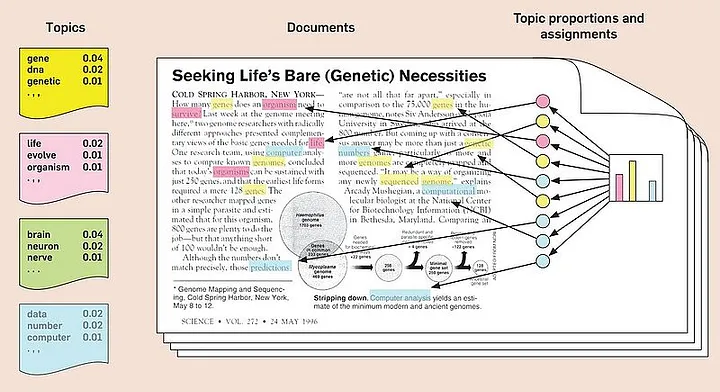

In [152]:
import pandas as pd

df = pd.read_csv('./data/movie_data.csv', encoding='utf-8')

# the following is necessary on some computers:
df = df.rename(columns={"0": "review", "1": "sentiment"})

df.head(3)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0


In [153]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english',
                        max_df=.1,
                        max_features=5000)
X = count.fit_transform(df['review'].values)
X.shape

(50000, 5000)

In [154]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                random_state=123,
                                learning_method='batch')
X_topics = lda.fit_transform(X)

In [155]:
lda.components_.shape

(10, 5000)

In [156]:
n_top_words = 5
feature_names = count.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f'Topic {(topic_idx + 1)}:')
    print(' '.join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
comedy jokes laugh humor fun
Topic 2:
guy girl sex women woman
Topic 3:
war american wife murder men
Topic 4:
human book feel audience documentary
Topic 5:
series tv episode dvd episodes
Topic 6:
horror gore house scary blood
Topic 7:
performance role wonderful beautiful family
Topic 8:
action john western killer hero
Topic 9:
script worst minutes awful budget
Topic 10:
action fun music animation disney


Based on reading the 5 most important words for each topic, we may guess that the LDA identified the following topics:
    
1. Generally bad movies (not really a topic category)
2. Movies about families
3. War movies
4. Art movies
5. Crime movies
6. Horror movies
7. Comedies
8. Movies somehow related to TV shows
9. Movies based on books
10. Action movies

To confirm that the categories make sense based on the reviews, let's plot 5 movies from the horror movie category (category 6 at index position 5):

In [157]:
horror = X_topics[:, 5].argsort()[::-1]

for iter_idx, movie_idx in enumerate(horror[:3]):
    print(f'\nHorror movie #{(iter_idx + 1)}:')
    print(df['review'][movie_idx][:300], '...')


Horror movie #1:
Over Christmas break, a group of college friends stay behind to help prepare the dorms to be torn down and replaced by apartment buildings. To make the work a bit more difficult, a murderous, Chucks-wearing psycho is wandering the halls of the dorm, preying on the group in various violent ways.<br / ...

Horror movie #2:
Basically, take the concept of every Asian horror ghost movie and smash it into one and you get this movie. The story goes like this: a bunch of college kids get voice mails from their own phones that are foretelling their deaths. There's some s*** going on with ghosts, which if you've seen any Asia ...

Horror movie #3:
I personally have a soft spot for horror films that are set in hospitals and asylums so I had a good feeling about watching this "Don't Look in the Basement", even though its reputation is doubtful. Well, turned out I was right! This is great, trashy entertainment with a couple of efficient shocks a ...


Using the preceeding code example, we printed the first 300 characters from the top 3 horror movies and indeed, we can see that the reviews -- even though we don't know which exact movie they belong to -- sound like reviews of horror movies, indeed. (However, one might argue that movie #2 could also belong to topic category 1.)